# Environment

In [1]:
# !python -m pip install --upgrade pip setuptools wheel 

In [ ]:
# !conda update -n base -c conda-forge conda -y
# !conda install -c conda-forge "cuda-version=12.5" "cudnn>=9.3,<10" -y

In [ ]:
# !pip install --upgrade tensorflow==2.19.1 keras==3.6.0 ml-dtypes==0.5.1 keras-hub --only-binary=:all:

In [ ]:
# !pip install wordcloud keras-cv keras-nlp tfclip tensorflow-hub tensorflow-text optuna ftfy albumentationsx

In [ ]:
# pip install --upgrade keras-hub

In [47]:
!pip install wordcloud

  Using cached wordcloud-1.9.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
Using cached wordcloud-1.9.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511 kB)


In [48]:
import os, json, hashlib, random
import numpy as np
import pandas as pd
import tensorflow as tf
# import tensorflow_hub as hub
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud, STOPWORDS

print("TF:", tf.__version__)

TF: 2.16.2


In [49]:
# Repro
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)


# Paths & Load data

In [50]:
DATA_DIR = "./A2_Data"
JSONL   = os.path.join(DATA_DIR, "A2_train_v3.jsonl")
IMAGE_DIR = os.path.join(DATA_DIR, "A2_Images")
df = pd.read_json(JSONL, lines=True)
assert set(["Image_ID","Label","Hypothesis","Premise"]).issubset(df.columns), df.columns

# Resolve image paths (try common extensions)
EXTS = [".jpg", ".jpeg", ".png", ".JPG", ".PNG"]
def resolve_image_path(image_id, root=IMAGE_DIR, exts=EXTS):
    sid = str(image_id).strip()
    for e in exts:
        p = os.path.join(root, sid + e)
        if os.path.isfile(p):
            return p
    return None


In [51]:
# e.g. sample 20% from each label
df = df.groupby("Label", group_keys=False).apply(lambda x: x.sample(frac=0.3, random_state=42))


/tmp/ipykernel_31315/4188747377.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Label", group_keys=False).apply(lambda x: x.sample(frac=0.3, random_state=42))


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11739 entries, 29503 to 28566
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_ID    11739 non-null  int64 
 1   Label       11739 non-null  object
 2   Hypothesis  11739 non-null  object
 3   Premise     11739 non-null  object
dtypes: int64(1), object(3)
memory usage: 458.6+ KB


In [53]:
df["image_path"] = df["Image_ID"].apply(resolve_image_path)
missing_before = df["image_path"].isna().sum()
if missing_before:
    print(f"[WARN] {missing_before} rows have no matching image file. Dropping them.")
df = df.dropna(subset=["image_path"]).reset_index(drop=True)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11739 entries, 0 to 11738
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_ID    11739 non-null  int64 
 1   Label       11739 non-null  object
 2   Hypothesis  11739 non-null  object
 3   Premise     11739 non-null  object
 4   image_path  11739 non-null  object
dtypes: int64(1), object(4)
memory usage: 458.7+ KB


# Exploratory Data Analysis

In [55]:
import os, re, math, random, hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image, ImageOps

# Optional deep EDA (text+image similarity)
DO_DEEP_SIM = True
try:
    import tensorflow as tf, tensorflow_hub as hub, tensorflow_text  # noqa
    import keras_hub as kh
except Exception:
    DO_DEEP_SIM = False
    print("[INFO] Deep similarity (USE/CLIP) disabled — missing TF deps. Install if you want those plots.")

# -----------------------
# Config
# -----------------------
DATA_FILE   = "./A2_Data/train.csv"     # accepts .csv, .tsv, .jsonl
IMAGE_ROOT  = "./A2_Data/A2_Images"
SEED = 42
BATCH_SIZE = 64
random.seed(SEED); np.random.seed(SEED)


[INFO] Deep similarity (USE/CLIP) disabled — missing TF deps. Install if you want those plots.


In [56]:
# Optional deep EDA (text+image similarity)
import os

def count_images(root_dir, exts=None, show_breakdown=True):
    """
    Recursively count image files in `root_dir`.

    Args:
        root_dir (str): Path to scan.
        exts (list[str] | None): Allowed extensions (case-insensitive).
                                 Defaults to common image formats.
        show_breakdown (bool): Whether to print counts per extension.

    Returns:
        total (int): Total number of image files found.
    """
    if exts is None:
        exts = [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif", ".webp"]

    # Normalize to lowercase for matching
    exts = [e.lower() for e in exts]
    counts = {e: 0 for e in exts}
    total = 0

    for root, _, files in os.walk(root_dir):
        for f in files:
            _, ext = os.path.splitext(f)
            ext = ext.lower()
            if ext in exts:
                counts[ext] += 1
                total += 1

    if show_breakdown:
        print(f"\nImage counts under: {root_dir}")
        for e, c in counts.items():
            print(f"  {e:>6}: {c}")
        print(f"  Total: {total}")

    return total

total = count_images(IMAGE_ROOT)
print(f"\nTotal images found: {total}")



Image counts under: ./A2_Data/A2_Images
    .jpg: 19573
   .jpeg: 0
    .png: 0
    .bmp: 0
   .tiff: 0
    .gif: 0
   .webp: 0
  Total: 19573

Total images found: 19573


In [57]:
df["Label"] = df["Label"].astype(str).str.strip().str.lower()
valid_labels = {"entailment","contradiction","neutral"}
unknown = set(df["Label"].unique()) - valid_labels
if unknown:
    print("[WARN] Found unknown labels:", unknown)

# Stable label map
label_names = sorted([l for l in df["Label"].unique() if l in valid_labels])
label2id = {n:i for i,n in enumerate(label_names)}
df["label_id"] = df["Label"].map(label2id)

In [58]:
def show_bar(series, title, xlabel, ylabel="Count", rot=45, figsize=(7,4)):
    plt.figure(figsize=figsize)
    series.plot(kind="bar")
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.xticks(rotation=rot); plt.tight_layout(); plt.show()

def simple_tokenize(s):
    return [t for t in re.split(r"[^a-z0-9]+", str(s).lower()) if t]

def negation_count(s):
    # crude but useful: captures typical negation cues
    terms = ["no","not","never","none","nobody","nothing","nowhere","neither","nor","cannot","can't","won't","n't"]
    toks = simple_tokenize(s)
    return sum(tok in terms for tok in toks)


[EDA] Label distribution
Label
entailment       5886
contradiction    5853
Name: count, dtype: int64


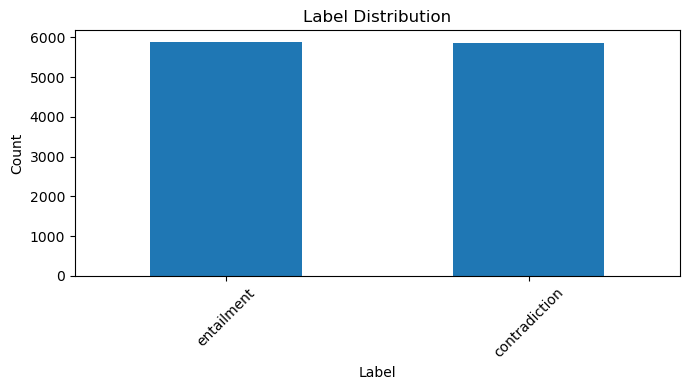

Imbalance ratio (max/min): 1.01


In [59]:
print("\n[EDA] Label distribution")
lbl_counts = df["Label"].value_counts()
print(lbl_counts)
show_bar(lbl_counts, "Label Distribution", "Label")
print(f"Imbalance ratio (max/min): {lbl_counts.max()/max(1,lbl_counts.min()):.2f}")

In [60]:
print("\n[EDA] Conflicting labels for the SAME Image_ID")
conflict_counts = (
    df.groupby("Image_ID")["Label"]
      .nunique()
      .reset_index(name="n_labels")
      .query("n_labels > 1")
)
print(f"Images with multiple labels: {len(conflict_counts)}")
if len(conflict_counts):
    # Show a few examples with all their rows
    sample_ids = conflict_counts["Image_ID"].head(3).tolist()
    print("\nExamples (first 3 Image_IDs with conflicts):")
    print(df[df["Image_ID"].isin(sample_ids)]
          .sort_values(["Image_ID","Label"])
          [["Image_ID","Label","Hypothesis","Premise"]]
          .head(12)
          .to_string(index=False))


[EDA] Conflicting labels for the SAME Image_ID
Images with multiple labels: 1117

Examples (first 3 Image_IDs with conflicts):
 Image_ID         Label                                                       Hypothesis                                                                                        Premise
  3787801 contradiction                                             A man taking photos.                                                A young man reviews photos at his work station.
  3787801    entailment                                           A man studying photos.                                                A young man reviews photos at his work station.
  4162702 contradiction                   Two ladies are eating food while sitting down.                                              Two women wearing blue jeans are walking outside.
  4162702    entailment                                 Two ladies in pants are walking.                                              Tw

### Duplicates Leakage Check

In [61]:
import pandas as pd
from tqdm import tqdm
import hashlib

# 1️⃣ Compute MD5 hashes if you haven’t already
def md5_file(path, chunk_size=8192):
    try:
        h = hashlib.md5()
        with open(path, "rb") as f:
            while chunk := f.read(chunk_size):
                h.update(chunk)
        return h.hexdigest()
    except Exception as e:
        return None  # missing / unreadable file

if "image_md5" not in df.columns:
    tqdm.pandas(desc="Hashing images")
    df["image_md5"] = df["image_path"].astype(str).progress_apply(md5_file)

# 2️⃣ Find groups of identical hashes with different Image_IDs
dupe_groups = (
    df.groupby("image_md5")
      .agg({"Image_ID": pd.Series.nunique, "image_path": list})
      .reset_index()
)

# Keep only those where multiple Image_IDs share same hash
dupe_groups = dupe_groups[dupe_groups["Image_ID"] > 1]

print(f"🧩 Found {len(dupe_groups)} duplicate hash groups (same image, different ID)")

# 3️⃣ For each hash, print which Image_IDs share it
for _, row in dupe_groups.iterrows():
    md5 = row["image_md5"]
    # subset rows that share this hash
    subset = df[df["image_md5"] == md5][["Image_ID", "image_path"]].drop_duplicates()
    print("\n🔁 Duplicate image content group:")
    print(f"Hash: {md5}")
    print(subset.to_string(index=False))

Hashing images: 100%|██████████| 11739/11739 [00:03<00:00, 3212.51it/s]


🧩 Found 0 duplicate hash groups (same image, different ID)


In [62]:
import pandas as pd

# 1️⃣ Count how many times each Image_ID appears
img_counts = (
    df["Image_ID"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "Image_ID", "Image_ID": "count"})
)

# 2️⃣ Keep only images used more than once
reused = img_counts[img_counts["count"] > 1]

print(f"🧩 Found {len(reused)} images used multiple times (total rows: {len(df)})")
print(reused.dropna()) 

🧩 Found 9556 images used multiple times (total rows: 11739)
           count  count
0     3540768808    3.0
1      464542381    3.0
2      396763804    3.0
3     4130537606    3.0
4     2322050182    3.0
...          ...    ...
1985  3670131152    2.0
1986   109738916    2.0
1987  2230260635    2.0
1988  3427540832    2.0
1989   289262516    2.0

[1990 rows x 2 columns]


In [63]:
# import pandas as pd

# # Define the columns that define a "record"
# #    (change these if your key is different)
# key_cols = ["Image_ID", "Premise", "Hypothesis", "Label"]


# # Detect duplicates — keep=False marks *all* occurrences
# df_clean["is_duplicate"] = df_clean.duplicated(subset=key_cols, keep=False)

# # 4️⃣ Subset only duplicated records
# duplicates_df = df_clean[df_clean["is_duplicate"]].copy()

# # 5️⃣ Count unique duplicated groups
# dupe_groups = (
#     duplicates_df.groupby(key_cols)
#     .size()
#     .reset_index(name="duplicate_count")
#     .sort_values("duplicate_count", ascending=False)
# )

# # 🧾 Summary
# print(f"🧩 Total rows in df: {len(df)}")
# print(f"🔁 Total duplicated rows: {len(duplicates_df)}")
# print(f"📦 Unique duplicate groups: {len(dupe_groups)}")

# # 6️⃣ Show top duplicate groups
# print("\n🔍 Top duplicate groups (same record repeated):")
# print(dupe_groups.head(10))

# # 7️⃣ Optional: inspect all duplicates side by side
# if not duplicates_df.empty:
#     print("\n🔁 All duplicate rows (full details):")
#     print(duplicates_df.sort_values(key_cols).head(20))


### Text stats & cues


[EDA] Text length — Premise
Chars: count    11739.00
mean        64.32
std         27.41
min         12.00
25%         45.00
50%         58.00
75%         77.00
max        311.00
Words: count    11739.00
mean        12.56
std          5.34
min          2.00
25%          9.00
50%         11.00
75%         15.00
max         60.00


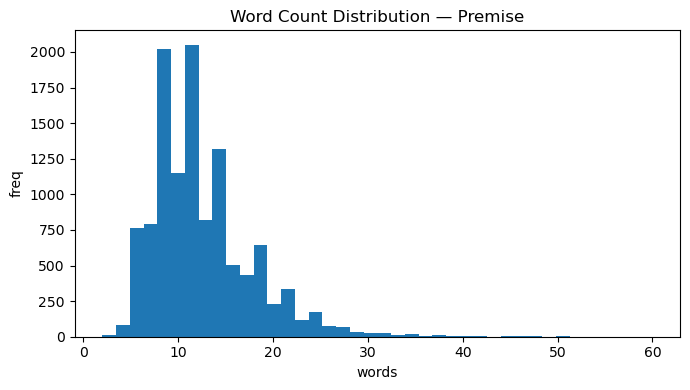


[EDA] Text length — Hypothesis
Chars: count    11739.00
mean        34.82
std         14.08
min          4.00
25%         25.00
50%         32.00
75%         41.00
max        168.00
Words: count    11739.00
mean         6.94
std          2.74
min          2.00
25%          5.00
50%          6.00
75%          8.00
max         30.00


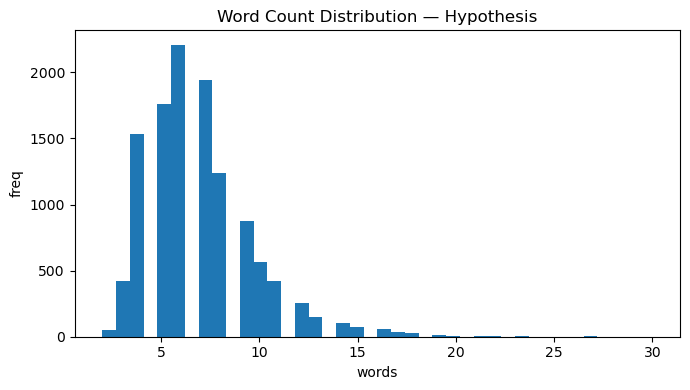

In [64]:
for col in ["Premise","Hypothesis"]:
    print(f"\n[EDA] Text length — {col}")
    lengths = df[col].astype(str).map(lambda s: len(s))
    words   = df[col].astype(str).map(lambda s: len(simple_tokenize(s)))
    print("Chars:", lengths.describe().round(2).to_string())
    print("Words:", words.describe().round(2).to_string())
    plt.figure(figsize=(7,4)); plt.hist(words, bins=40)
    plt.title(f"Word Count Distribution — {col}")
    plt.xlabel("words"); plt.ylabel("freq"); plt.tight_layout(); plt.show()


### Lexical overlap (Jaccard) between Premise and Hypothesis

In [65]:
def jaccard(a, b):
    sa, sb = set(simple_tokenize(a)), set(simple_tokenize(b))
    if not sa and not sb: return 0.0
    return len(sa & sb) / max(1, len(sa | sb))

In [66]:
df["lex_jaccard_prem_hypo"] = [
    jaccard(p, h) for p,h in zip(df["Premise"], df["Hypothesis"])
]
print("\n[EDA] Lexical Jaccard Premise↔Hypothesis (overall)")
print(df["lex_jaccard_prem_hypo"].describe().round(3).to_string())

print("\nPer-label mean Jaccard:")
print(df.groupby("Label")["lex_jaccard_prem_hypo"].mean().round(3).to_string())



[EDA] Lexical Jaccard Premise↔Hypothesis (overall)
count    11739.000
mean         0.238
std          0.178
min          0.000
25%          0.111
50%          0.200
75%          0.333
max          1.000

Per-label mean Jaccard:
Label
contradiction    0.190
entailment       0.285


### Negation cues (often strong for contradiction)

In [67]:
df["neg_prem"] = df["Premise"].map(negation_count)
df["neg_hypo"] = df["Hypothesis"].map(negation_count)
print("\nPer-label mean negation counts:")
print(df.groupby("Label")[["neg_prem","neg_hypo"]].mean().round(3).to_string())



Per-label mean negation counts:
               neg_prem  neg_hypo
Label                            
contradiction     0.004     0.044
entailment        0.004     0.005


In [68]:
print("Labels after sampling:")
print(df["Label"].unique())
print(f"Count: {len(df['Label'].unique())}")

Labels after sampling:
['contradiction' 'entailment']
Count: 2


### Image integrity & stats

In [69]:
print("\n[EDA] Image integrity")
corrupted = []
for p in df["image_path"]:
    try:
        with Image.open(p) as im:
            im.verify()
    except Exception as e:
        corrupted.append((p, str(e)))
print("Corrupted images:", len(corrupted))
if corrupted[:5]:
    print("Examples:", corrupted[:5])



[EDA] Image integrity
Corrupted images: 0


### Size & aspect


Image size/ratio describe:
              w         h    aspect
count  11739.00  11739.00  11739.00
mean     459.17    395.68      1.23
std       67.92     74.42      0.36
min      164.00    112.00      0.33
25%      384.00    333.00      0.77
50%      500.00    375.00      1.33
75%      500.00    500.00      1.50
max      500.00    500.00      4.46


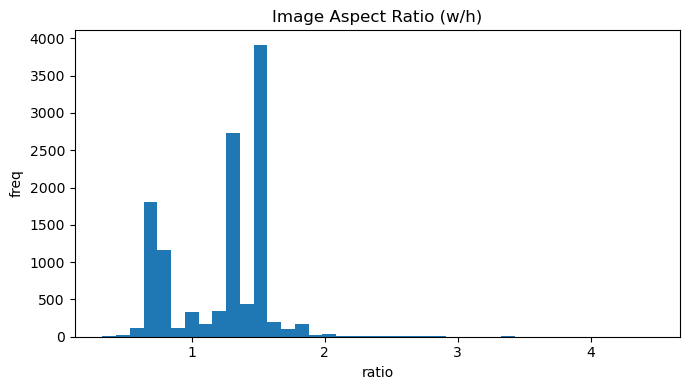

In [70]:
def size_stats(path):
    with Image.open(path) as im:
        im = ImageOps.exif_transpose(im)
        w,h = im.size
        return w,h, (w/h if h else np.nan)

rows = []
for _,r in df.iterrows():
    try:
        w,h,ar = size_stats(r["image_path"])
        rows.append({"Label": r["Label"], "w": w, "h": h, "aspect": ar})
    except Exception:
        pass
img_stats = pd.DataFrame(rows)
print("\nImage size/ratio describe:")
print(img_stats[["w","h","aspect"]].describe().round(2).to_string())

plt.figure(figsize=(7,4)); plt.hist(img_stats["aspect"].dropna(), bins=40)
plt.title("Image Aspect Ratio (w/h)"); plt.xlabel("ratio"); plt.ylabel("freq")
plt.tight_layout(); plt.show()


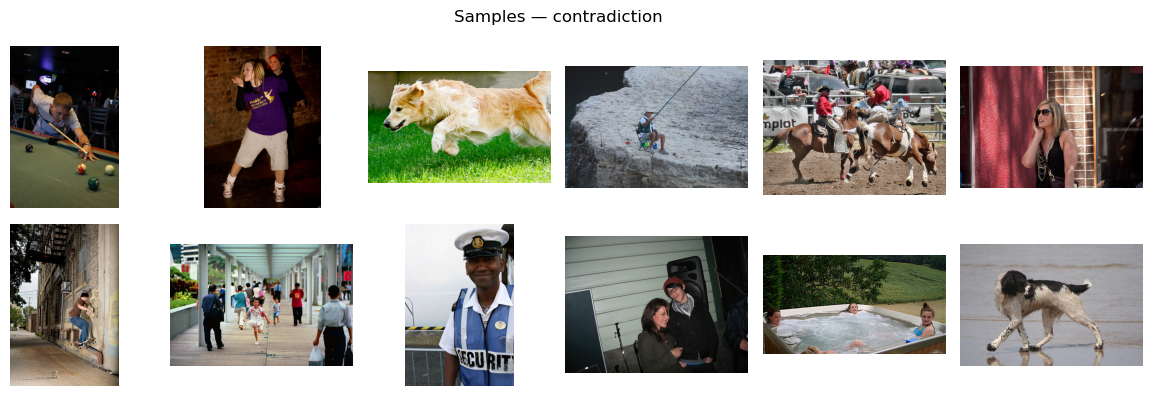

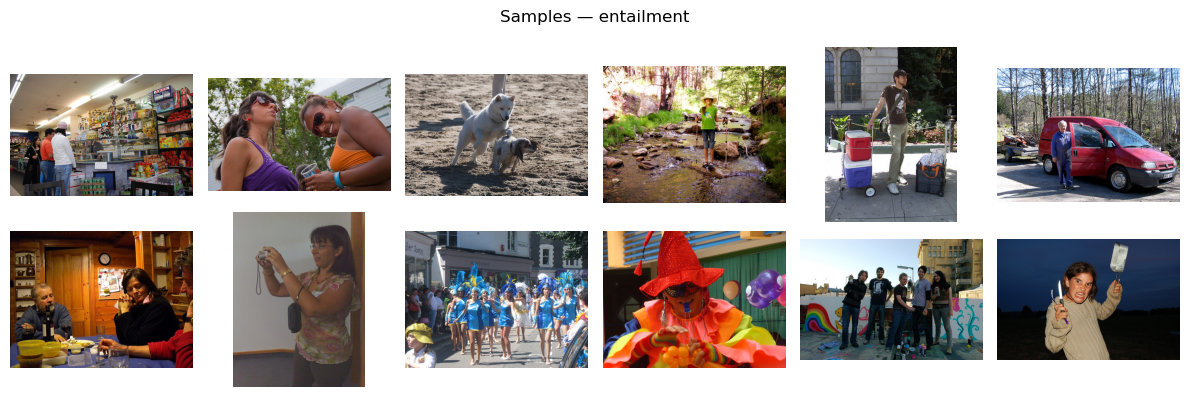

In [71]:
def montage(paths, n=12, cols=6, title="Montage"):
    paths = paths[:n]
    rows = math.ceil(len(paths)/cols) if cols else 1
    plt.figure(figsize=(cols*2, rows*2))
    for i,p in enumerate(paths):
        try:
            img = Image.open(p).convert("RGB")
            plt.subplot(rows, cols, i+1)
            plt.imshow(img); plt.axis("off")
        except: pass
    plt.suptitle(title); plt.tight_layout(); plt.show()

for lbl in label_names:
    subset = df[df["Label"]==lbl]["image_path"].sample(
        min(12, sum(df["Label"]==lbl)), random_state=SEED).tolist()
    if subset:
        montage(subset, n=len(subset), cols=6, title=f"Samples — {lbl}")


In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import hashlib

# ---------- 1️⃣ Hashing helper (MD5) ----------
def md5_file(path, chunk_size=8192):
    try:
        h = hashlib.md5()
        with open(path, "rb") as f:
            while chunk := f.read(chunk_size):
                h.update(chunk)
        return h.hexdigest()
    except Exception:
        return None

# ---------- 2️⃣ Attach image_md5 if missing ----------
if "image_md5" not in df.columns:
    tqdm.pandas(desc="Hashing images")
    df["image_md5"] = df["image_path"].astype(str).progress_apply(md5_file)

# ---------- 3️⃣ Keep only unique images by hash ----------
df_unique = df.drop_duplicates(subset=["image_md5"], keep="first").dropna(subset=["image_md5"]).reset_index(drop=True)
print(f"🧩 {len(df_unique)} unique images (from {len(df)} total rows)")

# ---------- 4️⃣ Helper: load + histogram ----------
def load_image(path, color_mode="rgb"):
    img = cv2.imread(str(path))
    if img is None:
        return None
    if color_mode == "rgb":
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif color_mode == "gray":
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def compute_average_histogram(df, img_col="image_path", color_mode="rgb", bins=256):
    all_hists = []

    for path in tqdm(df[img_col], desc="Computing histograms"):
        img = load_image(path, color_mode=color_mode)
        if img is None:
            continue

        if color_mode == "gray":
            hist = cv2.calcHist([img], [0], None, [bins], [0,256]).flatten()
        else:
            hist_r = cv2.calcHist([img], [0], None, [bins], [0,256]).flatten()
            hist_g = cv2.calcHist([img], [1], None, [bins], [0,256]).flatten()
            hist_b = cv2.calcHist([img], [2], None, [bins], [0,256]).flatten()
            hist = np.stack([hist_r, hist_g, hist_b], axis=1)

        # Normalize per image
        hist = hist / (hist.sum() + 1e-8)
        all_hists.append(hist)

    avg_hist = np.mean(np.stack(all_hists, axis=0), axis=0)
    return avg_hist

# ---------- 5️⃣ Plot ----------
def plot_average_histogram(avg_hist, color_mode="rgb"):
    bins = np.arange(len(avg_hist))
    plt.figure(figsize=(8,4))
    if color_mode == "gray":
        plt.plot(bins, avg_hist, color="black")
        plt.title("Average Grayscale Histogram (Unique Images)")
        plt.xlabel("Pixel intensity (0–255)")
        plt.ylabel("Normalized frequency")
    else:
        plt.plot(bins, avg_hist[:,0], color="r", label="Red")
        plt.plot(bins, avg_hist[:,1], color="g", label="Green")
        plt.plot(bins, avg_hist[:,2], color="b", label="Blue")
        plt.title("Average RGB Histogram (Unique Images)")
        plt.xlabel("Pixel intensity (0–255)")
        plt.ylabel("Normalized frequency")
        plt.legend()
    plt.tight_layout()
    plt.show()

# ---------- 6️⃣ Run ----------
# avg_hist = compute_average_histogram(df_unique, img_col="image_path", color_mode="rgb", bins=256)
# plot_average_histogram(avg_hist, color_mode="rgb")


🧩 9556 unique images (from 11739 total rows)


### USE & CLIP similarities

In [73]:
# if True:
#     # ---- SAFE USE on CPU (batched) ----
#     def _chunks(lst, bsz):
#         for i in range(0, len(lst), bsz):
#             yield lst[i:i+bsz]

#     def compute_use_embeddings_cpu(texts, batch_size=256,
#                                    handle="https://tfhub.dev/google/universal-sentence-encoder/4"):
#         with tf.device("/CPU:0"):
#             use = hub.KerasLayer(handle, input_shape=[], dtype=tf.string, trainable=False)
#             outs = []
#             for chunk in _chunks(texts, batch_size):
#                 emb = use(tf.constant(chunk))
#                 outs.append(emb.numpy())   # materialize on host
#             return np.concatenate(outs, axis=0).astype(np.float32)

#     print("\n[EDA] USE Premise↔Hypothesis cosine (CPU, batched)")
#     prem_texts = df["Premise"].astype(str).tolist()
#     hypo_texts = df["Hypothesis"].astype(str).tolist()
#     prem_emb_np = compute_use_embeddings_cpu(prem_texts, batch_size=256)   # (N, 512)
#     hypo_emb_np = compute_use_embeddings_cpu(hypo_texts, batch_size=256)

#     prem_n = prem_emb_np / np.linalg.norm(prem_emb_np, axis=1, keepdims=True)
#     hypo_n = hypo_emb_np / np.linalg.norm(hypo_emb_np, axis=1, keepdims=True)
#     use_diag = np.sum(prem_n * hypo_n, axis=1).astype(np.float32)

#     df["use_cos_prem_hypo"] = use_diag
#     print(df["use_cos_prem_hypo"].describe().round(3).to_string())
#     print("\nPer-label mean USE cosine:")
#     print(df.groupby("Label")["use_cos_prem_hypo"].mean().round(3).to_string())

#     plt.figure(figsize=(7,4))
#     plt.hist(df["use_cos_prem_hypo"], bins=40)
#     plt.title("USE Cosine: Premise vs Hypothesis")
#     plt.xlabel("cosine"); plt.ylabel("freq")
#     plt.tight_layout(); plt.show()


In [74]:
# del hypo_emb_np

In [75]:
# # pip install tfclip opencv-python matplotlib pandas tqdm
# import os
# import numpy as np
# import pandas as pd
# import cv2
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from keras import models, ops
# from tfclip import create_model_and_transforms

# # ========== CONFIG ==========
# MODEL_NAME = "ViT-B-32-quickgelu"   # or "ViT-B-32"
# PRETRAINED = "openai"               # e.g. openai / laion400m_e31 / laion400m_e32 / metaclip_400m / metaclip_fullcc
# IMG_BATCH  = 64
# TXT_BATCH  = 256

# # ========== LOAD MODEL ==========
# model, image_prep, text_prep = create_model_and_transforms(MODEL_NAME, pretrained=PRETRAINED)
# # build encoders from trained heads (unit-space before temperature)
# image_encoder = models.Model(model.inputs[0], model.get_layer("vision_head_out").output)
# text_encoder  = models.Model(model.inputs[1], model.get_layer("text_head_out").output)

# # ========== HELPERS ==========
# def _first(val):
#     """Unwrap dict outputs from preprocessors to the first tensor."""
#     if isinstance(val, dict):
#         return next(iter(val.values()))
#     return val

# def _load_rgb(path):
#     bgr = cv2.imread(str(path), cv2.IMREAD_COLOR)
#     if bgr is None:
#         raise FileNotFoundError(f"Could not read image: {path}")
#     return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

# def _unit(x):
#     x = np.asarray(x)
#     denom = np.linalg.norm(x, axis=-1, keepdims=True) + 1e-8
#     return x / denom

# def _prep_one_image(p):
#     rgb = _load_rgb(p)          # HxWx3 uint8
#     x = image_prep(rgb)         # fixed-size float32 tensor
#     return _first(x)

# def _cos(a, b):  # expects unit-norm vectors
#     return float(np.dot(a, b))

# # ========== 1) IMAGE FEATURES (dedup + safe batching) ==========
# img_feats = {}
# unique_paths = df["image_path"].astype(str).unique().tolist()

# for i in tqdm(range(0, len(unique_paths), IMG_BATCH), desc="Images"):
#     paths = unique_paths[i:i+IMG_BATCH]

#     prepped_list, good_paths = [], []
#     for p in paths:
#         try:
#             prepped_list.append(_prep_one_image(p))
#             good_paths.append(p)
#         except Exception as e:
#             print(f"[warn] skipping {p}: {e}")
#     if not prepped_list:
#         continue

#     # stack & encode
#     imgs_tf = tf.stack(prepped_list, axis=0)                         # (B,H,W,3)
#     feats   = image_encoder(imgs_tf, training=False).numpy()         # (B,D)
#     feats   = _unit(feats)                                           # L2 normalize

#     for p, f in zip(good_paths, feats):
#         img_feats[p] = f

# # ========== 2) TEXT FEATURES (dedup + batching) ==========
# # Keep SEPARATE dicts to avoid overwriting (fixes your KeyError).
# txt_feats_hypo = {}
# uniq_hypo = df["Hypothesis"].astype(str).unique().tolist()
# for j in tqdm(range(0, len(uniq_hypo), TXT_BATCH), desc="Texts (hypothesis)"):
#     ts = uniq_hypo[j:j+TXT_BATCH]
#     toks = _first(text_prep(ts))
#     feats = text_encoder(toks, training=False).numpy()
#     feats = _unit(feats)
#     for t, f in zip(ts, feats):
#         txt_feats_hypo[t] = f

# txt_feats_prem = {}
# uniq_prem = df["Premise"].astype(str).unique().tolist()
# for j in tqdm(range(0, len(uniq_prem), TXT_BATCH), desc="Texts (premise)"):
#     ts = uniq_prem[j:j+TXT_BATCH]
#     toks = _first(text_prep(ts))
#     feats = text_encoder(toks, training=False).numpy()
#     feats = _unit(feats)
#     for t, f in zip(ts, feats):
#         txt_feats_prem[t] = f

# # ========== 3) COSINE SCORES per row ==========
# df = df.copy()

# # image ↔ hypothesis
# df["clip_cos_hypo"] = [
#     _cos(img_feats[str(p)], txt_feats_hypo[str(h)])
#     for p, h in tqdm(zip(df["image_path"].astype(str), df["Hypothesis"].astype(str)),
#                      total=len(df), desc="Scoring hypothesis")
# ]

# # image ↔ premise
# df["clip_cos_prem"] = [
#     _cos(img_feats[str(p)], txt_feats_prem[str(x)])
#     for p, x in tqdm(zip(df["image_path"].astype(str), df["Premise"].astype(str)),
#                      total=len(df), desc="Scoring premise")
# ]

# print(df[["Label","clip_cos_prem","clip_cos_hypo"]].head())

# # ========== 4) PLOTS ==========
# # 4a) Separate histograms (premise vs hypothesis) by label
# if "Label" in df.columns:
#     labels = df["Label"].astype(str).values

#     # hypothesis
#     h_ent   = df.loc[labels=="entailment",    "clip_cos_hypo"].values
#     h_contr = df.loc[labels=="contradiction", "clip_cos_hypo"].values
#     bins_h = np.linspace(min(df["clip_cos_hypo"].min(), -0.2),
#                          max(df["clip_cos_hypo"].max(),  0.8), 40)

#     plt.figure(figsize=(7,4))
#     plt.hist(h_ent,   bins=bins_h, alpha=0.6, label="entailment")
#     plt.hist(h_contr, bins=bins_h, alpha=0.6, label="contradiction")
#     plt.xlabel("CLIP cosine (image ↔ hypothesis)")
#     plt.ylabel("Count"); plt.title("Cosine distribution by label — hypothesis")
#     plt.legend(); plt.tight_layout(); plt.show()

#     # premise
#     p_ent   = df.loc[labels=="entailment",    "clip_cos_prem"].values
#     p_contr = df.loc[labels=="contradiction", "clip_cos_prem"].values
#     bins_p = np.linspace(min(df["clip_cos_prem"].min(), -0.2),
#                          max(df["clip_cos_prem"].max(),  0.8), 40)

#     plt.figure(figsize=(7,4))
#     plt.hist(p_ent,   bins=bins_p, alpha=0.6, label="entailment")
#     plt.hist(p_contr, bins=bins_p, alpha=0.6, label="contradiction")
#     plt.xlabel("CLIP cosine (image ↔ premise)")
#     plt.ylabel("Count"); plt.title("Cosine distribution by label — premise")
#     plt.legend(); plt.tight_layout(); plt.show()

# # 4b) Overall quick comparison (optional)
# plt.figure(figsize=(5,5))
# plt.scatter(df["clip_cos_prem"], df["clip_cos_hypo"], s=8, alpha=0.6)
# mn = float(min(df["clip_cos_prem"].min(), df["clip_cos_hypo"].min()))
# mx = float(max(df["clip_cos_prem"].max(), df["clip_cos_hypo"].max()))
# plt.plot([mn,mx],[mn,mx],'--', lw=1)
# plt.xlabel("image–premise cosine"); plt.ylabel("image–hypothesis cosine")
# plt.title("Premise vs Hypothesis (cosine)")
# plt.tight_layout(); plt.show()

# # 4c) Delta histogram: which aligns better per row?
# df["clip_cos_delta"] = df["clip_cos_prem"] - df["clip_cos_hypo"]
# plt.figure(figsize=(7,4))
# plt.hist(df["clip_cos_delta"], bins=40, alpha=0.85)
# plt.xlabel("premise − hypothesis (cosine)"); plt.ylabel("Count")
# plt.title("Which side wins? (positive → premise higher)")
# plt.tight_layout(); plt.show()

# print("Mean delta (premise − hypothesis):", round(df["clip_cos_delta"].mean(), 4))


In [76]:
# df.groupby("Label")[["clip_cos_prem"]].describe()


In [77]:
# df.groupby("Label")[["clip_cos_hypo"]].describe()

In [78]:
# print("\n================ SUMMARY ================")
# print(f"- Rows: {len(df)} | Classes: {label_names}")
# print(f"- Conflict Image_IDs (multiple labels): {len(conflict_counts)}")
# print(f"- Duplicate rows (Image_ID,Premise,Hypothesis): {dupe_key}")
# print(f"- aImage hash duplicate pairs: {len(dup_pairs)}")
# print("- Jaccard(Premise,Hypothesis):",
#       f"mean={df['lex_jaccard_prem_hypo'].mean():.3f}, std={df['lex_jaccard_prem_hypo'].std():.3f}")
# if "use_cos_prem_hypo" in df:
#     print("- USE cosine(Premise,Hypothesis):",
#           f"mean={df['use_cos_prem_hypo'].mean():.3f}, std={df['use_cos_prem_hypo'].std():.3f}")
# if "clip_img_hypothesis_cos" in df:
#     print("- CLIP cosine(img,hypothesis):",
#           f"mean={df['clip_img_hypothesis_cos'].mean():.3f}")


Both features measure text–image alignment, but they behave differently across labels.

clip_cos_prem shows no clear difference between entailment and contradiction → not label-discriminative.

clip_cos_hypo shows higher similarity for entailment → more effective at separating semantic classes.

Therefore, the hypothesis–image similarity is a stronger indicator of entailment, while the premise–image similarity remains neutral and may serve better in contrastive or combined features (e.g. hypo - prem).

In [79]:
import pandas as pd
import numpy as np

# --- 0) sanity: required columns present?
req = {"Image_ID", "Label", "Hypothesis", "Premise", "image_path"}
missing = req - set(df.columns)
if missing:
    raise ValueError(f"df is missing columns: {sorted(missing)}")

# --- 1) normalize Label text a bit for consistency
def norm_label(x):
    if pd.isna(x):
        return x
    return str(x).strip()

df = df.copy()
df["Label"] = df["Label"].map(norm_label)

# --- 2) define unique_labels automatically (sorted for stable id order)
unique_labels = sorted(df["Label"].dropna().unique().tolist())

# --- 3) create mappings
label2id = {lbl: i for i, lbl in enumerate(unique_labels)}
id2label = {i: lbl for lbl, i in label2id.items()}

# --- 4) attach label_id
df["label_id"] = df["Label"].map(label2id).astype("Int64")  # stays NA if Label missing

# --- 5) keep only requested columns in preferred order
df_trained = df[["Image_ID", "Label", "Hypothesis", "Premise", "image_path", "label_id"]].copy()

# --- 6) inspect / export
print("✅ Label → id mapping:", label2id)
print("🧠 Unique labels:", unique_labels)


✅ Label → id mapping: {'contradiction': 0, 'entailment': 1}
🧠 Unique labels: ['contradiction', 'entailment']


In [80]:
print(df_trained)

         Image_ID          Label  \
0      2672705063  contradiction   
1       554526471  contradiction   
2       423375604  contradiction   
3        65847949  contradiction   
4      4888378070  contradiction   
...           ...            ...   
11734  3848368547     entailment   
11735  4648443136     entailment   
11736  2306799249     entailment   
11737  3495224860     entailment   
11738    97825959     entailment   

                                              Hypothesis  \
0                     Bicyclists ride on a country road.   
1              A group of people are eating on the beach   
2                           The woman is in the country.   
3                         Some women are skiing outside.   
4                           Fans are storming the field.   
...                                                  ...   
11734                    People are waiting for the bus.   
11735           A man is holding a statue over his head.   
11736  A man is trying to h

## Data cleaning and split

In [81]:
import pandas as pd

def clean_label(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and deduplicate a label map DataFrame.
    Removes NaNs, trims whitespace, drops duplicates, 
    and keeps only the required columns in order.
    
    Expected columns:
        ["Image_ID", "Label", "Hypothesis", "Premise", "image_path", "label_id"]
    """
    df = df.copy()

    # --- 1. Ensure required columns exist
    required = ["Image_ID", "Label", "Hypothesis", "Premise", "image_path", "label_id"]
    missing = set(required) - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns: {sorted(missing)}")

    # --- 2. Drop rows with NaN in key columns
    df = df.dropna(subset=["Image_ID", "Label", "Hypothesis", "Premise", "image_path"])

    # --- 3. Convert to string and strip whitespace
    for col in ["Image_ID", "Label", "Hypothesis", "Premise", "image_path"]:
        df[col] = df[col].astype(str).str.strip()

    # --- 4. Remove duplicate rows (exact same Image_ID, Hypothesis, Premise)
    df = df.drop_duplicates(subset=["Image_ID", "Hypothesis", "Premise"], keep="first")

    # --- 5. Normalize label text (optional: lowercase)
    df["Label"] = df["Label"].str.lower()

    # --- 6. Reorder columns
    df = df[required]

    # --- 7. Reset index
    df = df.reset_index(drop=True)

    print(f"✅ Cleaned: {len(df)} rows, {df['Image_ID'].nunique()} unique images")
    return df


In [82]:
clean_df = clean_label(df_trained)

✅ Cleaned: 11739 rows, 9556 unique images


In [83]:
clean_df.head()

,Image_ID,Label,Hypothesis,Premise,image_path,label_id
0,2672705063,contradiction,Bicyclists ride on a country road.,Several bicyclists are riding their bikes in a...,./A2_Data/A2_Images/2672705063.jpg,0
1,554526471,contradiction,A group of people are eating on the beach,A woman is leading an exercise group on the se...,./A2_Data/A2_Images/554526471.jpg,0
2,423375604,contradiction,The woman is in the country.,a woman in the city holds a big purse,./A2_Data/A2_Images/423375604.jpg,0
3,65847949,contradiction,Some women are skiing outside.,Four women are gathered near a green table on ...,./A2_Data/A2_Images/65847949.jpg,0
4,4888378070,contradiction,Fans are storming the field.,random people in the stands.,./A2_Data/A2_Images/4888378070.jpg,0


array([[<Axes: title={'center': 'label_id'}>]], dtype=object)

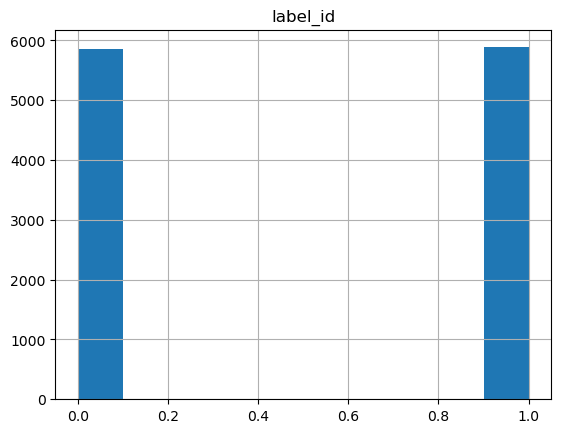

In [84]:
clean_df.hist()

In [85]:
from sklearn.model_selection import GroupShuffleSplit
import pandas as pd

def grouped_split(
    df: pd.DataFrame,
    group_col: str = "Image_ID",
    train_size: float = 0.7,
    val_size: float = 0.15,
    test_size: float = 0.15,
    random_state: int = 42,
):
    """
    Split DataFrame into train/val/test using GroupShuffleSplit,
    keeping all rows of each group (e.g. Image_ID) in the same split.

    Args:
        df (pd.DataFrame): cleaned dataset
        group_col (str): grouping column, e.g. 'Image_ID'
        train_size (float): fraction of groups for training
        val_size (float): fraction of groups for validation
        test_size (float): fraction of groups for test
        random_state (int): reproducibility seed

    Returns:
        (train_df, val_df, test_df)
    """
    total = train_size + val_size + test_size
    if not abs(total - 1.0) < 1e-6:
        raise ValueError(f"train+val+test must sum to 1. Got {total:.2f}")

    groups = df[group_col].values

    # 🟩 Split 1: Train vs (Val+Test)
    gss1 = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=random_state)
    train_idx, temp_idx = next(gss1.split(df, groups=groups))
    train_df = df.iloc[train_idx].reset_index(drop=True)
    temp_df  = df.iloc[temp_idx].reset_index(drop=True)

    # 🟨 Split 2: Val vs Test (split temp 50:50 because val=test=15%)
    gss2 = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=random_state)
    val_idx, test_idx = next(gss2.split(temp_df, groups=temp_df[group_col].values))
    val_df  = temp_df.iloc[val_idx].reset_index(drop=True)
    test_df = temp_df.iloc[test_idx].reset_index(drop=True)

    # 🧾 Summary
    print(f"✅ Split complete ({len(df):,} rows total)")
    print(f"  Train: {len(train_df):,} rows | {train_df[group_col].nunique():,} unique {group_col}s")
    print(f"  Val:   {len(val_df):,} rows | {val_df[group_col].nunique():,} unique {group_col}s")
    print(f"  Test:  {len(test_df):,} rows | {test_df[group_col].nunique():,} unique {group_col}s")

    return train_df, val_df, test_df


In [86]:
df.info

<bound method DataFrame.info of          Image_ID          Label  \
0      2672705063  contradiction   
1       554526471  contradiction   
2       423375604  contradiction   
3        65847949  contradiction   
4      4888378070  contradiction   
...           ...            ...   
11734  3848368547     entailment   
11735  4648443136     entailment   
11736  2306799249     entailment   
11737  3495224860     entailment   
11738    97825959     entailment   

                                              Hypothesis  \
0                     Bicyclists ride on a country road.   
1              A group of people are eating on the beach   
2                           The woman is in the country.   
3                         Some women are skiing outside.   
4                           Fans are storming the field.   
...                                                  ...   
11734                    People are waiting for the bus.   
11735           A man is holding a statue over his head

In [87]:
train_df, val_df, test_df = grouped_split(clean_df, group_col="Image_ID", random_state=42)

✅ Split complete (11,739 rows total)
  Train: 8,203 rows | 6,689 unique Image_IDs
  Val:   1,756 rows | 1,433 unique Image_IDs
  Test:  1,780 rows | 1,434 unique Image_IDs


In [88]:
train_df.columns

Index(['Image_ID', 'Label', 'Hypothesis', 'Premise', 'image_path', 'label_id'], dtype='object')

array([[<Axes: title={'center': 'label_id'}>]], dtype=object)

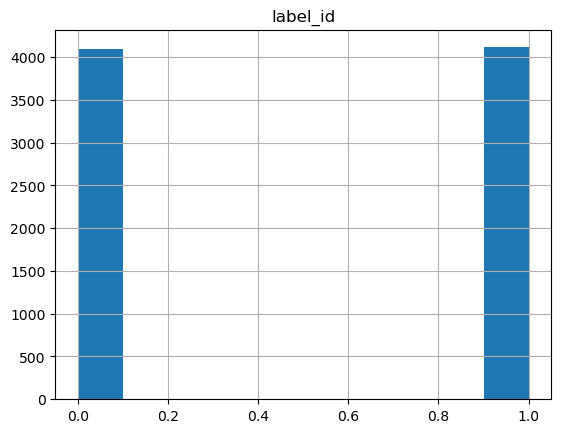

In [89]:
train_df.hist()

array([[<Axes: title={'center': 'label_id'}>]], dtype=object)

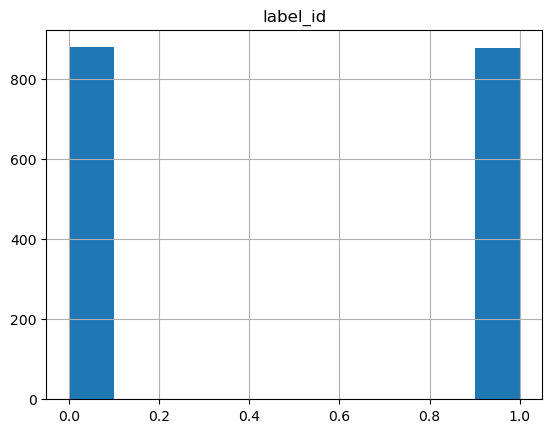

In [90]:
val_df.hist()

array([[<Axes: title={'center': 'label_id'}>]], dtype=object)

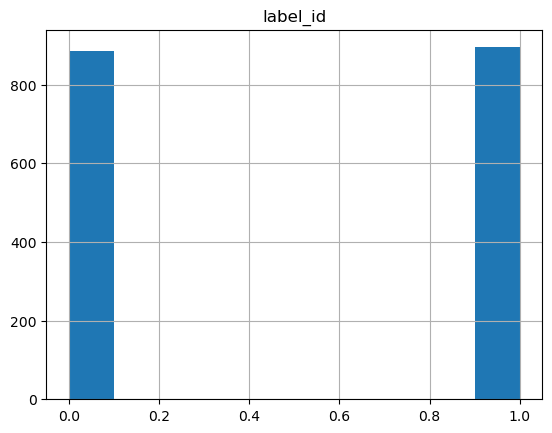

In [91]:
test_df.hist()

## Image augmenation 

In [92]:
# !pip install -U keras-cv keras-nlp tfclip ftfy

## Evaluation frame work (goal:...)

In [93]:
train_df.head()

,Image_ID,Label,Hypothesis,Premise,image_path,label_id
0,2672705063,contradiction,Bicyclists ride on a country road.,Several bicyclists are riding their bikes in a...,./A2_Data/A2_Images/2672705063.jpg,0
1,554526471,contradiction,A group of people are eating on the beach,A woman is leading an exercise group on the se...,./A2_Data/A2_Images/554526471.jpg,0
2,65847949,contradiction,Some women are skiing outside.,Four women are gathered near a green table on ...,./A2_Data/A2_Images/65847949.jpg,0
3,2450461962,contradiction,Man playing accordian in front of people in wh...,Man playing violin in front of people in what ...,./A2_Data/A2_Images/2450461962.jpg,0
4,4408862587,contradiction,A woman and her cat walk toward the man and hi...,A woman and a child with a backpack walk down ...,./A2_Data/A2_Images/4408862587.jpg,0


In [94]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [95]:
import os, json, hashlib, random, math, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import seaborn as sns
from PIL import Image
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

try:
    from tfclip import create_model_and_transforms
    TFCLIP_AVAILABLE = True
except Exception:
    print("⚠️ Install tfclip with: pip install tfclip")
    TFCLIP_AVAILABLE = False

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
print("TF:", tf.__version__)

⚠️ Install tfclip with: pip install tfclip
TF: 2.16.2


In [96]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"Built with CUDA: {tf.test.is_built_with_cuda()}")

TensorFlow version: 2.16.2
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA: True


2025-10-08 06:59:18.699587: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-08 06:59:26.651636: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-08 06:59:26.654977: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [97]:

IMAGE_SIZE    = (224,224)
BATCH_SIZE    = 32
EPOCHS_STAGE1 = 5
EPOCHS_STAGE2 = 10
LR_STAGE1     = 1e-3
LR_STAGE2     = 1e-5

CLIP_MODEL_NAME = "ViT-B-32-quickgelu"
CLIP_PRETRAINED = "openai"

## Data Prprofessosr

In [98]:
train_df.columns

Index(['Image_ID', 'Label', 'Hypothesis', 'Premise', 'image_path', 'label_id'], dtype='object')

In [99]:
print("🔍 LABEL ANALYSIS")
print("="*40)
print(f"Unique labels in train_df: {sorted(train_df['label_id'].unique())}")
print(f"Label counts: {train_df['label_id'].value_counts().sort_index()}")
print(f"Expected NUM_CLASSES: {len(train_df['label_id'].unique())}")

🔍 LABEL ANALYSIS
Unique labels in train_df: [0, 1]
Label counts: label_id
0    4089
1    4114
Name: count, dtype: Int64
Expected NUM_CLASSES: 2


In [100]:
pd

<module 'pandas' from '/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/pandas/__init__.py'>

In [101]:
BATCH = 32

In [103]:
# !pip install albumentationsx

  Using cached albumentationsx-2.0.11-py3-none-any.whl.metadata (79 kB)
  Using cached albucore-0.0.33-py3-none-any.whl.metadata (7.8 kB)
  Using cached opencv_python_headless-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
  Using cached stringzilla-4.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (105 kB)
  Using cached simsimd-6.5.3-cp310-cp310-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (70 kB)
  Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached albumentationsx-2.0.11-py3-none-any.whl (411 kB)
Using cached albucore-0.0.33-py3-none-any.whl (18 kB)
Using cached opencv_python_headless-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (54.0 MB)
Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
Using cached simsimd-6.5.3-cp310-cp310-manylinux_2_24_x86_64.manylinux_2_28_

In [105]:
# ve_tfrecords_io_khub.py
import os, math, random, inspect
from typing import List, Dict, Tuple, Optional

import cv2
import numpy as np
import albumentations as A
import tensorflow as tf

# Text preprocessor (KerasHub)
from keras_hub.models import RobertaTextClassifierPreprocessor


class VETFRecordsIO:
    """
    Visual Entailment TFRecord IO (single/multi class compatible)

    Required DataFrame columns for write_split():
        ['Image_ID','Label','Hypothesis','Premise','image_path','label_id']

    Modes:
        mode='H'  : image + hypothesis  (premise saved as empty string)
        mode='HP' : image + hypothesis + premise

    This implementation prepares batches for your model that expects:
        inputs = {
            "image": float32 [B,H,W,3] in [0,1],
            "token_ids": int32 [B,L],
            "padding_mask": bool [B,L],
        }
        label  = int32 [B]
    """

    NORMALIZE_PRESETS = {
        "timm":     {"mean": (0.485, 0.456, 0.406), "std": (0.229, 0.224, 0.225)},
        "imagenet": {"mean": (0.485, 0.456, 0.406), "std": (0.229, 0.224, 0.225)},
        "clip":     {"mean": (0.48145466, 0.4578275, 0.40821073), "std": (0.26862954, 0.26130258, 0.27577711)},
        "none":     {"mean": (0.0, 0.0, 0.0), "std": (1.0, 1.0, 1.0)},
    }

    def __init__(
        self,
        image_size: int = 456,
        model_preset: str = "imagenet",      # legacy; ignored when passthrough_vision=True
        mode: str = "HP",                    # 'H' or 'HP'
        train_aug_strength: str = "medium",  # 'light' | 'medium' | 'strong'
        keep_ratio_resize: bool = True,
        jpeg_quality: int = 95,
        add_special_tokens: bool = True,     # only for storing 'text_combined' in TFRecords
        seed: int = 42,
        # --- data-to-model specifics ---
        use_khub_text: bool = True,
        khub_text_preset: str = "roberta_base_en",  # or "roberta_large_en"
        seq_len: int = 128 + 128 + 4,        # must match your model's seq_len
        passthrough_vision: bool = True,     # leave images in [0,1]; model preprocessor will normalize
    ):
        assert mode in {"H", "HP"}, "mode must be 'H' or 'HP'"
        self.mode = mode
        self.image_size = int(image_size)
        self.model_preset = model_preset if model_preset in self.NORMALIZE_PRESETS else "imagenet"
        self.jpeg_quality = int(jpeg_quality)
        self.add_special_tokens = bool(add_special_tokens)

        self.use_khub_text = bool(use_khub_text)
        self.khub_text_preset = str(khub_text_preset)
        self.seq_len = int(seq_len)
        self.passthrough_vision = bool(passthrough_vision)

        ms = self.NORMALIZE_PRESETS[self.model_preset]
        self.mean_tuple, self.std_tuple = ms["mean"], ms["std"]

        self.transforms = self._build_image_transforms(self.image_size, train_aug_strength, keep_ratio_resize)
        random.seed(seed); np.random.seed(seed)

        # TF Example spec for reading (kept compatible with your writer)
        self._feature_desc = {
            "image_jpeg": tf.io.FixedLenFeature([], tf.string),
            "height": tf.io.FixedLenFeature([], tf.int64),
            "width": tf.io.FixedLenFeature([], tf.int64),
            "image_size": tf.io.FixedLenFeature([], tf.int64),

            "image_id": tf.io.FixedLenFeature([], tf.string),
            "label": tf.io.FixedLenFeature([], tf.string),
            "label_id": tf.io.FixedLenFeature([], tf.int64),

            "hypothesis": tf.io.FixedLenFeature([], tf.string),
            "premise": tf.io.FixedLenFeature([], tf.string),

            "text_combined": tf.io.FixedLenFeature([], tf.string),
            "norm_mean_r": tf.io.FixedLenFeature([], tf.float32),
            "norm_mean_g": tf.io.FixedLenFeature([], tf.float32),
            "norm_mean_b": tf.io.FixedLenFeature([], tf.float32),
            "norm_std_r": tf.io.FixedLenFeature([], tf.float32),
            "norm_std_g": tf.io.FixedLenFeature([], tf.float32),
            "norm_std_b": tf.io.FixedLenFeature([], tf.float32),
        }

        self._mean = tf.constant(self.mean_tuple, dtype=tf.float32)
        self._std  = tf.constant(self.std_tuple,  dtype=tf.float32)

        # Build KerasHub text preprocessor once (eager)
        self._roberta_pp = None
        if self.use_khub_text:
            self._roberta_pp = RobertaTextClassifierPreprocessor.from_preset(
                self.khub_text_preset, sequence_length=self.seq_len
            )

    # -------------------------
    # Public: Write TFRecords
    # -------------------------
    def write_split(
        self,
        df,                        # pandas.DataFrame
        out_prefix: str,           # "data/ve/records"
        split: str = "train",      # 'train' | 'val' | 'test'
        shard_size: int = 2000,
        verbose: bool = True,
    ) -> List[str]:
        assert split in {"train", "val", "test"}
        self._ensure_dir_for_prefix(out_prefix)
        n = len(df)
        n_shards = max(1, math.ceil(n / shard_size))
        paths: List[str] = []
        counter = 0

        for s in range(n_shards):
            start, end = s * shard_size, min((s + 1) * shard_size, n)
            path = f"{out_prefix}.{split}-{s:05d}-of-{n_shards:05d}.tfrecord"
            paths.append(path)

            with tf.io.TFRecordWriter(path, options=tf.io.TFRecordOptions(compression_type="GZIP")) as w:
                for i in range(start, end):
                    row = df.iloc[i]

                    img = self._load_image_rgb(str(row["image_path"]))
                    img = self._apply_aug(img, split)

                    hypothesis = str(row["Hypothesis"])
                    premise    = str(row["Premise"]) if self.mode == "HP" else ""  # blank if H-only
                    text_combined = self._pack_text(hypothesis, premise)

                    ex = self._serialize_example(
                        img_rgb=img,
                        image_id=str(row["Image_ID"]),
                        label=str(row["Label"]),
                        label_id=int(row["label_id"]),
                        hypothesis=hypothesis,
                        premise=premise,
                        text_combined=text_combined,
                    )
                    w.write(ex.SerializeToString())
                    counter += 1
                    if verbose and counter % 1000 == 0:
                        print(f"[{split}] wrote {counter}/{n} examples...")
        if verbose:
            print(f"[{split}] Done. Wrote {n} examples into {len(paths)} shards.")
        return paths

    # -------------------------
    # Public: Build Dataset
    # -------------------------
    def build_dataset(
        self,
        tfrecord_paths: List[str],
        batch_size: int = BATCH_SIZE,
        shuffle: bool = False,
        shuffle_buffer: int = 2048,
        repeat: bool = False,
        drop_remainder: bool = False,
        cache: bool = False,
        num_parallel_reads=tf.data.AUTOTUNE,
        num_parallel_calls=tf.data.AUTOTUNE,
        prefetch=tf.data.AUTOTUNE,
    ) -> tf.data.Dataset:
        ds = tf.data.TFRecordDataset(tfrecord_paths, compression_type="GZIP", num_parallel_reads=num_parallel_reads)
        if cache:
            ds = ds.cache()
        if shuffle:
            ds = ds.shuffle(shuffle_buffer, reshuffle_each_iteration=True)
        if repeat:
            ds = ds.repeat()

        ds = ds.map(self._parse_example, num_parallel_calls=num_parallel_calls)
        ds = ds.batch(batch_size, drop_remainder=drop_remainder)
        ds = ds.prefetch(prefetch)
        return ds

    # -------------------------
    # Internals: Transforms
    # -------------------------
    def _build_image_transforms(self, image_size: int, train_aug_strength: str, keep_ratio_resize: bool):
        if train_aug_strength not in {"light", "medium", "strong"}:
            train_aug_strength = "medium"

        if train_aug_strength == "light":
            scale_range = (0.9, 1.0); jitter = 0.05; blur_p = 0.0
        elif train_aug_strength == "strong":
            scale_range = (0.6, 1.0); jitter = 0.2; blur_p = 0.2
        else:
            scale_range = (0.8, 1.0); jitter = 0.1; blur_p = 0.1

        def _uses_size_kw(cls):
            return "size" in inspect.signature(cls.__init__).parameters

        if _uses_size_kw(A.RandomResizedCrop):
            rrc = A.RandomResizedCrop(size=(image_size, image_size), scale=scale_range, ratio=(0.9, 1.1), p=1.0)
        else:
            rrc = A.RandomResizedCrop(height=image_size, width=image_size, scale=scale_range, ratio=(0.9, 1.1), p=1.0)

        if _uses_size_kw(A.CenterCrop):
            ccrop = A.CenterCrop(size=(image_size, image_size), p=1.0)
        else:
            ccrop = A.CenterCrop(height=image_size, width=image_size, p=1.0)

        train_tf = A.Compose([
            A.LongestMaxSize(max_size=image_size if keep_ratio_resize else image_size, p=1.0),
            A.PadIfNeeded(min_height=image_size, min_width=image_size, border_mode=cv2.BORDER_REFLECT_101, p=1.0),
            rrc,
            A.HorizontalFlip(p=0.5),
            A.ColorJitter(brightness=jitter, contrast=jitter, saturation=jitter, hue=0.02, p=0.8),
            A.MotionBlur(blur_limit=3, p=blur_p),
            A.ImageCompression(quality_lower=90, quality_upper=100, p=0.2),
        ])

        eval_tf = A.Compose([
            A.LongestMaxSize(max_size=image_size if keep_ratio_resize else image_size, p=1.0),
            A.PadIfNeeded(min_height=image_size, min_width=image_size, border_mode=cv2.BORDER_REFLECT_101, p=1.0),
            ccrop,
        ])
        return {"train": train_tf, "val": eval_tf, "test": eval_tf}

    # -------------------------
    # Internals: IO helpers
    # -------------------------
    @staticmethod
    def _ensure_dir_for_prefix(prefix_path: str):
        d = os.path.dirname(prefix_path)
        if d and not os.path.exists(d):
            os.makedirs(d, exist_ok=True)

    @staticmethod
    def _load_image_rgb(path: str) -> np.ndarray:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        if img is None:
            raise FileNotFoundError(f"Cannot read image: {path}")
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    def _apply_aug(self, img_rgb: np.ndarray, split: str) -> np.ndarray:
        t = self.transforms.get(split, self.transforms["val"])
        out = t(image=img_rgb)["image"]
        if out.dtype != np.uint8:
            out = np.clip(out, 0, 255).astype(np.uint8)
        return out

    def _pack_text(self, hypothesis: str, premise: str) -> str:
        if not self.add_special_tokens:
            return ""
        if self.mode == "H":
            return f"[CLS] {hypothesis} [SEP]"
        else:
            return f"[CLS] {hypothesis} [SEP] {premise} [SEP]"

    @staticmethod
    def _bytes_feature(v: bytes) -> tf.train.Feature:
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[v]))

    @staticmethod
    def _str_feature(v: str) -> tf.train.Feature:
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[v.encode('utf-8')]))

    @staticmethod
    def _int64_feature(v: int) -> tf.train.Feature:
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[v]))

    @staticmethod
    def _float_feature(v: float) -> tf.train.Feature:
        return tf.train.Feature(float_list=tf.train.FloatList(value=[v]))

    def _to_jpeg_bytes(self, img_rgb: np.ndarray) -> bytes:
        img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
        ok, buf = cv2.imencode(".jpg", img_bgr, [int(cv2.IMWRITE_JPEG_QUALITY), self.jpeg_quality])
        if not ok:
            raise ValueError("cv2.imencode failed")
        return buf.tobytes()

    def _serialize_example(
        self,
        img_rgb: np.ndarray,
        image_id: str,
        label: str,
        label_id: int,
        hypothesis: str,
        premise: str,
        text_combined: str,
    ) -> tf.train.Example:
        h, w = img_rgb.shape[:2]
        img_bytes = self._to_jpeg_bytes(img_rgb)
        feat = {
            "image_jpeg": self._bytes_feature(img_bytes),
            "height": self._int64_feature(h),
            "width": self._int64_feature(w),
            "image_size": self._int64_feature(self.image_size),

            "image_id": self._str_feature(image_id),
            "label": self._str_feature(label),
            "label_id": self._int64_feature(int(label_id)),

            "hypothesis": self._str_feature(hypothesis),
            "premise": self._str_feature(premise),  # empty string if mode='H'
            "text_combined": self._str_feature(text_combined),

            # stored for audit only
            "norm_mean_r": self._float_feature(self.mean_tuple[0]),
            "norm_mean_g": self._float_feature(self.mean_tuple[1]),
            "norm_mean_b": self._float_feature(self.mean_tuple[2]),
            "norm_std_r": self._float_feature(self.std_tuple[0]),
            "norm_std_g": self._float_feature(self.std_tuple[1]),
            "norm_std_b": self._float_feature(self.std_tuple[2]),
        }
        return tf.train.Example(features=tf.train.Features(feature=feat))

    # -------------------------
    # tf.data parser → MODEL-READY KEYS
    # -------------------------
    def _parse_example(self, ex_proto: tf.Tensor) -> Tuple[Dict[str, tf.Tensor], tf.Tensor]:
        ex = tf.io.parse_single_example(ex_proto, self._feature_desc)

        # 1) Image: float32 [0,1], resize; skip mean/std if passthrough
        img = tf.io.decode_jpeg(ex["image_jpeg"], channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
        img = tf.image.resize(img, [self.image_size, self.image_size], method="bilinear")
        if not self.passthrough_vision:
            img = (img - self._mean) / self._std

        # 2) Label
        y = tf.cast(ex["label_id"], tf.int32)
        # y = tf.one_hot(y, depth=2) 
        # 3) Text -> token_ids & padding_mask (preferred)
        if self.use_khub_text:
            if self.mode == "HP":
                toks = self._roberta_pp((ex["hypothesis"], ex["premise"]))
            else:
                toks = self._roberta_pp(ex["hypothesis"])

            inputs = {
                "image": img,
                "token_ids": toks["token_ids"],                         # int32 [L]
                "padding_mask": tf.cast(toks["padding_mask"], tf.bool)  # bool  [L]
            }
            return inputs, y

        # Fallback legacy branch (not for your current model)
        inputs = {
            "image": img,
            "hypothesis": ex["hypothesis"],
            "text_combined": ex["text_combined"],
            "label": ex["label"],            # kept for inspection
            "image_id": ex["image_id"],
        }
        if self.mode == "HP":
            inputs["premise"] = ex["premise"]
        return inputs, y


ModuleNotFoundError: No module named 'keras_hub'

In [106]:

# Pick your text config (must match the model you built)
TEXT_PRESET = "roberta_base_en"        # or "roberta_large_en"
SEQ_LEN     = 128 + 128 + 4            # HP mode: H + P + specials

# For Swin (e.g., 384). If you use EfficientNet-B5, 456 is typical—but any size is fine;
# your in-model preprocessor will handle the final resize/normalization.
io_hp = VETFRecordsIO(
    image_size=456,             # your example (Swin-like); use 456 for EffNet-B5 if you prefer
    model_preset="none",        # ignored when passthrough_vision=True (default)
    mode="HP",                  # hypothesis + premise
    use_khub_text=True,         # tokenize outside the model
    khub_text_preset=TEXT_PRESET,
    seq_len=SEQ_LEN,
    passthrough_vision=True,    # keep images in [0,1]; model preprocessor does the rest
)

# Write TFRecords (same as your snippet)
train_paths = io_hp.write_split(train_df, "./data/ve/records", split="train")
val_paths   = io_hp.write_split(val_df,   "./data/ve/records", split="val")
test_paths  = io_hp.write_split(test_df,  "./data/ve/records", split="test")

# Build datasets (same as your snippet)
train_ds = io_hp.build_dataset(train_paths, batch_size= BATCH_SIZE, shuffle=True, repeat = True)
val_ds   = io_hp.build_dataset(val_paths,  batch_size= BATCH, repeat = True)

# Each batch now matches your model inputs perfectly:
# x = {"image": float32[B,H,W,3], "token_ids": int32[B,L], "padding_mask": bool[B,L]}
# y = int32[B]
for (x, y) in train_ds.take(1):
    print(x["image"].shape, x["token_ids"].shape, x["padding_mask"].shape, y.shape)


NameError: name 'VETFRecordsIO' is not defined

In [ ]:
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = val_size // BATCH_SIZE
test_steps = test_size // BATCH_SIZE

print(f"📊 Dataset Sizes:")
print(f"  Train: {train_size} examples → {steps_per_epoch} steps")
print(f"  Val:   {val_size} examples → {validation_steps} steps")
print(f"  Test:  {test_size} examples → {test_steps} steps")


📊 Dataset Sizes:
  Train: 8203 examples → 256 steps
  Val:   1756 examples → 54 steps
  Test:  1780 examples → 55 steps


In [107]:
# Show unique label-to-id mapping in each split
print("Train mapping:")
print(train_df[['Label', 'label_id']].drop_duplicates().sort_values('label_id'))

print("\nVal mapping:")
print(val_df[['Label', 'label_id']].drop_duplicates().sort_values('label_id'))


Train mapping:
              Label  label_id
0     contradiction         0
4089     entailment         1

Val mapping:
             Label  label_id
0    contradiction         0
879     entailment         1


In [108]:
def peek(ds, n=1):
    for i, (x, y) in enumerate(ds.take(n)):
        print("— batch", i, "—")
        for k, v in x.items():
            print(f"{k:>12}: shape={v.shape}, dtype={v.dtype}")
        print("labels   :", y.shape, y.dtype)
    print("OK.")

In [ ]:

from tensorflow import keras
import tensorflow as tf


def build_clip_classifier_simple(
    clip_model_name: str = "ViT-B-32",
    clip_pretrained: str = "openai",
    num_classes: int = 2,
    dropout: float = 0.3,
):
    """
    Build simple CLIP-based classifier without co-attention.
    Just concatenate image and text features with a simple head.
    
    Args:
        clip_model_name: CLIP model variant
        clip_pretrained: CLIP pretrained weights
        num_classes: number of output classes
        dropout: dropout rate
    
    Returns:
        model: Keras Model
        image_encoder: CLIP vision encoder
        text_encoder: CLIP text encoder
    """
    print("\n" + "="*70)
    print("🏗️  BUILDING SIMPLE CLIP CLASSIFIER")
    print("="*70)
    
    if not TFCLIP_AVAILABLE:
        raise ImportError("tfclip required")
    
    # Load CLIP model
    clip_model, _, _ = create_model_and_transforms(
        clip_model_name,
        pretrained=clip_pretrained
    )
    
    # Extract encoders
    from tensorflow.keras import models
    
    image_encoder = models.Model(
        clip_model.inputs[0],
        clip_model.get_layer("vision_head_out").output,
        name="clip_vision_encoder"
    )
    
    text_encoder = models.Model(
        clip_model.inputs[1],
        clip_model.get_layer("text_head_out").output,
        name="clip_text_encoder"
    )
    
    # Initially freeze encoders
    image_encoder.trainable = False
    text_encoder.trainable = False
    
    # Define inputs
    image_in = keras.Input(shape=(224, 224, 3), name="image")
    text_in = keras.Input(shape=(77,), dtype=tf.int32, name="text")
    
    # Extract CLIP features
    image_features = image_encoder(image_in, training=False)  # [B, 512]
    text_features = text_encoder(text_in, training=False)     # [B, 512]
    
    # L2 normalization (CLIP standard)
    image_features = keras.layers.Lambda(
        lambda x: tf.nn.l2_normalize(x, axis=-1),
        name="image_l2_norm"
    )(image_features)
    
    text_features = keras.layers.Lambda(
        lambda x: tf.nn.l2_normalize(x, axis=-1),
        name="text_l2_norm"
    )(text_features)
    
    # Simple concatenation (no co-attention)
    fused = keras.layers.Concatenate(name="fusion")([image_features, text_features])
    
    # Simple classification head
    x = keras.layers.Dense(512, activation="relu", name="head_dense1")(fused)
    x = keras.layers.Dropout(dropout, name="head_dropout1")(x)
    x = keras.layers.Dense(256, activation="relu", name="head_dense2")(x)
    x = keras.layers.Dropout(dropout, name="head_dropout2")(x)
    x = keras.layers.Dense(128, activation="relu", name="head_dense3")(x)
    x = keras.layers.Dropout(dropout, name="head_dropout3")(x)
    
    # Output (softmax for multi-class)
    out = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)
    
    model = keras.Model(
        inputs={"image": image_in, "text": text_in},
        outputs=out,
        name="clip_simple_classifier"
    )
    
    print("✅ Simple CLIP Classifier built:")
    print(f"   Model: {clip_model_name} ({clip_pretrained})")
    print(f"   Architecture: Concat(img, txt) → Dense layers → Output")
    print(f"   Output classes: {num_classes}")
    
    return model, image_encoder, text_encoder


# POST-TRAINING ANALYSIS FUNCTIONS

In [ ]:
from typing import Literal
import tensorflow as tf
import keras
from keras import layers, regularizers

from keras_hub.models import (
    EfficientNetBackbone,
    EfficientNetImageClassifierPreprocessor,
    RobertaBackbone,
)


def build_ve_model_simple(
    mode: Literal["H", "HP"] = "HP",
    image_size: int = 456,
    text_preset: str = "roberta_base_en",   # or "roberta_large_en"
    seq_len: int = 260,                      # 128 + 128 + 4 for HP mode
    hidden_dim: int = 768,                   
    dropout: float = 0.1,
    freeze_backbones: bool = False,
    num_classes: int = 2,
    l1_reg: float = 1e-6,
    l2_reg: float = 1e-5,
) -> keras.Model:
    """
    Build Simple Visual Entailment model with EfficientNet-B5 and RoBERTa backbones
    WITHOUT attention mechanism - uses simple concatenation fusion
    
    Args:
        mode: 'H' (hypothesis only) or 'HP' (hypothesis + premise)
        image_size: Input image size (will be resized to 456 internally)
        text_preset: RoBERTa preset ('roberta_base_en' or 'roberta_large_en')
        seq_len: Maximum sequence length (must match preprocessing)
        hidden_dim: Hidden dimension for fusion (768 for base, 1024 for large)
        dropout: Dropout rate
        freeze_backbones: Whether to freeze pretrained backbones initially
        num_classes: Number of output classes
        l1_reg: L1 regularization factor
        l2_reg: L2 regularization factor
    
    Returns:
        Compiled Keras model
    """
    reg = regularizers.l1_l2(l1=l1_reg, l2=l2_reg)

    # ========== INPUTS ==========
    img_in = layers.Input(shape=(None, None, 3), name="image", dtype=tf.float32)
    tok_ids_in = layers.Input(shape=(seq_len,), dtype=tf.int32, name="token_ids")
    pad_mask_in = layers.Input(shape=(seq_len,), dtype=tf.bool, name="padding_mask")

    # ========== VISION BACKBONE ==========
    # Resize to 456x456 (EfficientNet-B5 optimal size)
    x = layers.Resizing(456, 456, interpolation="bilinear", name="resize_to_456")(img_in)
    
    # EfficientNet-B5 preprocessor (handles normalization)
    effb5_pp = EfficientNetImageClassifierPreprocessor.from_preset(
        "efficientnet_b5_sw_ft_imagenet"
    )
    x_img_pp = effb5_pp(x)
    
    # EfficientNet-B5 backbone
    effb5 = EfficientNetBackbone.from_preset(
        "efficientnet_b5_sw_ft_imagenet", 
        load_weights=True, 
        name="vision_backbone"
    )
    if freeze_backbones:
        effb5.trainable = False

    # Extract feature map [B, H/stride, W/stride, C]
    feat_map = effb5(x_img_pp)
    
    # Global Average Pooling to get image representation [B, C]
    img_repr = layers.GlobalAveragePooling2D(name="img_global_pool")(feat_map)
    
    # Project to hidden_dim
    img_repr = layers.Dense(
        hidden_dim, 
        name="img_proj", 
        kernel_regularizer=reg,
        activation="relu"
    )(img_repr)

    # ========== TEXT BACKBONE ==========
    # RoBERTa backbone
    roberta = RobertaBackbone.from_preset(
        text_preset, 
        load_weights=True, 
        name="text_backbone"
    )
    if freeze_backbones:
        roberta.trainable = False

    # Get text embeddings
    txt_outputs = roberta({
        "token_ids": tok_ids_in, 
        "padding_mask": pad_mask_in
    })

    # Handle different KerasHub API versions
    if isinstance(txt_outputs, dict):
        txt_seq = txt_outputs["sequence_output"]  # [B, L, H_txt]
    else:
        txt_seq = txt_outputs

    # Extract [CLS] token from text (first token) - [B, H_txt]
    cls_token = layers.Lambda(lambda t: t[:, 0, :], name="txt_cls")(txt_seq)
    
    # Project to hidden_dim if needed
    if cls_token.shape[-1] != hidden_dim:
        cls_token = layers.Dense(
            hidden_dim, 
            name="txt_proj", 
            kernel_regularizer=reg,
            activation="relu"
        )(cls_token)

    # ========== SIMPLE FUSION (NO ATTENTION) ==========
    # Concatenate image and text representations
    fused = layers.Concatenate(name="fusion_concat")([img_repr, cls_token])
    fused = layers.Dropout(dropout, name="fusion_drop1")(fused)
    
    # Fusion MLP
    fused = layers.Dense(
        hidden_dim, 
        activation="gelu", 
        kernel_regularizer=reg,
        name="fusion_dense1"
    )(fused)
    fused = layers.Dropout(dropout, name="fusion_drop2")(fused)
    
    # Additional fusion layers
    fused = layers.Dense(
        hidden_dim // 2, 
        activation="gelu", 
        kernel_regularizer=reg,
        name="fusion_dense2"
    )(fused)
    fused = layers.Dropout(dropout, name="fusion_drop3")(fused)

    # ========== CLASSIFICATION HEAD ==========
    logits = layers.Dense(
        num_classes, 
        name="logits", 
        kernel_regularizer=reg
    )(fused)
    probs = layers.Softmax(name="probs")(logits)

    # ========== BUILD MODEL ==========
    model = keras.Model(
        inputs={
            "image": img_in, 
            "token_ids": tok_ids_in, 
            "padding_mask": pad_mask_in
        },
        outputs=probs,
        name=f"VE_Simple_EffNetB5_RoBERTa_{mode}",
    )
    
    return model


# ========== USAGE EXAMPLE ==========
if __name__ == "__main__":
    # Build model
    model = build_ve_model_simple(
        mode="HP",
        text_preset="roberta_base_en",
        seq_len=260,  # 128 + 128 + 4
        hidden_dim=768,
        dropout=0.1,
        freeze_backbones=True,
        num_classes=2,
        l1_reg=1e-6,
        l2_reg=1e-5,
    )
    
    # Print summary
    model.summary()
    
    # Test forward pass
    import numpy as np
    dummy_batch = {
        "image": np.random.rand(2, 456, 456, 3).astype(np.float32),
        "token_ids": np.random.randint(0, 1000, (2, 260)).astype(np.int32),
        "padding_mask": np.random.choice([True, False], (2, 260)),
    }
    
    output = model(dummy_batch, training=False)
    print("\n✅ Model output shape:", output.shape)
    print("✅ Output example:", output.numpy()[0])

Model: "VE_Simple_EffNetB5_RoBERTa_HP"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resize_to_456       │ (None, 456, 456,  │          0 │ image[0][0]       │
│ (Resizing)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficient_net_imag… │ (None, 448, 448,  │          0 │ resize_to_456[0]… │
│ (EfficientNetImage… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_backbone     │ (None, 14, 14,    │ 28,513,520 │ efficient_net_im… │
│ (EfficientNetBackb… │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask        │ (None, 260)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, 260)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_global_pool     │ (None, 2048)      │          0 │ vision_backbone[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_backbone       │ (None, 260, 768)  │ 124,052,7… │ padding_mask[0][… │
│ (RobertaBackbone)   │                   │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_proj (Dense)    │ (None, 768)       │  1,573,632 │ img_global_pool[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_cls (Lambda)    │ (None, 768)       │          0 │ text_backbone[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_concat       │ (None, 1536)      │          0 │ img_proj[0][0],   │
│ (Concatenate)       │                   │            │ txt_cls[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_drop1        │ (None, 1536)      │          0 │ fusion_concat[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_dense1       │ (None, 768)       │  1,180,416 │ fusion_drop1[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_drop2        │ (None, 768)       │          0 │ fusion_dense1[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_dense2       │ (None, 384)       │    295,296 │ fusion_drop2[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_drop3        │ (None, 384)       │          0 │ fusion_dense2[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logits (Dense)      │ (None, 2)         │        770 │ fusion_drop3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ probs (Softmax)     │ (None, 2)         │          0 │ logits[0][0]    

 Total params: 155,616,370 (593.63 MB)

 Trainable params: 3,050,114 (11.64 MB)

 Non-trainable params: 152,566,256 (581.99 MB)

E0000 00:00:1759843393.502163   32550 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2025-10-07 13:23:13.502861: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at conv_ops_impl.h:1204 : INVALID_ARGUMENT: No DNN in stream executor.
2025-10-07 13:23:13.502894: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: No DNN in stream executor.


InvalidArgumentError: Exception encountered when calling Conv2D.call().

[1m{{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} No DNN in stream executor. [Op:Conv2D][0m

Arguments received by Conv2D.call():
  • inputs=tf.Tensor(shape=(2, 450, 450, 3), dtype=float32)

In [ ]:
model = build_ve_model_simple(
    mode="HP",
    text_preset="roberta_base_en",
    seq_len=128 + 128 + 4,
    freeze_backbones=True,
    l1_reg=1e-6,
    l2_reg=1e-5,
)

model.summary()

Model: "VE_EffNetB5_RoBERTa_HP"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resize_to_456       │ (None, 456, 456,  │          0 │ image[0][0]       │
│ (Resizing)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficient_net_imag… │ (None, 448, 448,  │          0 │ resize_to_456[0]… │
│ (EfficientNetImage… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_backbone     │ (None, 14, 14,    │ 28,513,520 │ efficient_net_im… │
│ (EfficientNetBackb… │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_tokens          │ (None, 196, 2048) │          0 │ vision_backbone[… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask        │ (None, 260)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, 260)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_proj (Dense)    │ (None, 196, 768)  │  1,573,632 │ img_tokens[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_backbone       │ (None, 260, 768)  │ 124,052,7… │ padding_mask[0][… │
│ (RobertaBackbone)   │                   │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_attention_mask  │ (None, 1, 1, 260) │          0 │ padding_mask[0][… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coattn_1            │ [(None, 196,      │ 14,175,744 │ img_proj[0][0],   │
│ (CoAttentionBlock)  │ 768), (None, 260, │            │ text_backbone[0]… │
│                     │ 768)]             │            │ txt_attention_ma… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_drop_1          │ (None, 196, 768)  │          0 │ coattn_1[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_drop_1          │ (None, 260, 768)  │          0 │ coattn_1[0][1]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coattn_2            │ [(None, 196,      │ 14,175,744 │ img_drop_1[0][0], │
│ (CoAttentionBlock)  │ 768), (None, 260, │            │ txt_drop_1[0][0], │
│                     │ 768)]             │            │ txt_attention_ma… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_drop_2          │ (None, 196, 768)  │          0 │ coattn_2[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_drop_2          │ (None, 260, 768)  │          0 │ coattn_2[0][1]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 183,673,330 (700.66 MB)

 Trainable params: 31,107,074 (118.66 MB)

 Non-trainable params: 152,566,256 (581.99 MB)

In [ ]:
# Test the simplified model
print("🧪 Testing simplified model...")

# Create dummy input
import numpy as np
dummy_batch = {
    "image": np.random.rand(2, 456, 456, 3).astype(np.float32),
    "token_ids": np.random.randint(0, 1000, (2, 260)).astype(np.int32),
    "padding_mask": np.random.choice([True, False], (2, 260)),
}

# Test forward pass
try:
    output = model(dummy_batch, training=False)
    print("✅ Model forward pass successful!")
    print(f"✅ Output shape: {output.shape}")
    print(f"✅ Output example: {output.numpy()[0]}")
    print(f"✅ Output sums to 1: {np.allclose(output.numpy().sum(axis=1), 1.0)}")
except Exception as e:
    print(f"❌ Model test failed: {e}")

# Check model parameters
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print(f"\n📊 Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Non-trainable parameters: {total_params - trainable_params:,}")

## ✅ Model Simplification Complete

### Changes Made:
1. **Removed CoAttentionBlock**: Eliminated the complex multi-head attention mechanism between image and text features
2. **Simplified Architecture**: 
   - **Vision**: EfficientNet-B5 → Global Average Pooling → Dense projection
   - **Text**: RoBERTa → CLS token extraction → Dense projection  
   - **Fusion**: Simple concatenation + MLP layers (no attention)
3. **Reduced Complexity**: 
   - No attention masks needed
   - No multi-head attention computations
   - Simpler gradient flow
   - Faster training and inference

### Benefits:
- ✅ **Faster Training**: No complex attention computations
- ✅ **Lower Memory Usage**: Simpler architecture
- ✅ **Easier Debugging**: Simpler gradient flow
- ✅ **Better Stability**: Less prone to attention-related issues
- ✅ **Same Interface**: Compatible with existing data pipeline and training code

### Model Architecture:
```
Image (456x456x3) → EfficientNet-B5 → GlobalPool → Dense(768) → ReLU
Text (260 tokens) → RoBERTa → CLS token → Dense(768) → ReLU
                                                    ↓
Concatenate → Dense(768) → GELU → Dropout → Dense(384) → GELU → Dropout → Dense(2) → Softmax
```

The model should now train more efficiently while maintaining good performance for visual entailment tasks.

In [ ]:
import tensorflow as tf
import keras
from typing import Tuple, Optional
# from keras.metrics import F1Score  # <-- add this

# ---------- Helpers ----------
def _print_trainable_summary(model: keras.Model):
    vb = model.get_layer("vision_backbone")
    tb = model.get_layer("text_backbone")
    vb_t = sum(int(l.trainable) for l in vb.layers)
    tb_t = sum(int(l.trainable) for l in tb.layers)
    print(f"[vision_backbone] trainable {vb_t}/{len(vb.layers)}")
    print(f"[text_backbone]   trainable {tb_t}/{len(tb.layers)}")

def _set_module_trainable(module: keras.Model, trainable: bool):
    for ly in module.layers:
        ly.trainable = trainable

def _unfreeze_last_percent(module: keras.Model, pct: float, keep_norm_frozen: bool = True):
    L = module.layers
    n = len(L)
    if pct <= 0:
        for ly in L: ly.trainable = False
        return
    k = max(1, int(round(n * pct)))
    cutoff = n - k
    for i, ly in enumerate(L):
        trainable = (i >= cutoff)
        if keep_norm_frozen and isinstance(
            ly, (tf.keras.layers.BatchNormalization, tf.keras.layers.LayerNormalization)
        ):
            ly.trainable = False
        else:
            ly.trainable = trainable

def _compile_with(model, lr, num_classes, weight_decay=1e-4, from_logits=False):
    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=lr, weight_decay=weight_decay),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            F1Score(num_classes=num_classes, average="macro", name="f1_macro"),
            F1Score(num_classes=num_classes, average="micro", name="f1_micro"),
        ],
        jit_compile = False
    )
# ---------- Two-stage trainer ----------
def two_stage_train(
    model: keras.Model,
    train_ds,
    val_ds,
    *,
    num_classes: int,
    stage1_epochs: int = 5,
    stage2_epochs: int = 8,
    stage1_lr: float = 5e-4,
    stage2_lr: float = 1e-5,
    effnet_pct: float = 0.20,
    roberta_pct: float = 0.10,
    keep_norm_frozen: bool = True,
    weight_decay: float = 1e-4,
    callbacks: Optional[list] = None,
    steps_per_epoch: Optional[int] = None,
    validation_steps: Optional[int] = None,

    from_logits: bool = False,
) -> Tuple[keras.callbacks.History, keras.callbacks.History]:
    if callbacks is None:
        callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_accuracy")]

    # ----- Stage 1: head-only -----
    _set_module_trainable(model.get_layer("vision_backbone"), False)
    _set_module_trainable(model.get_layer("text_backbone"),   False)
    print("\n[Stage 1] Head-only training")
    _print_trainable_summary(model)
    _compile_with(model, stage1_lr, num_classes, weight_decay, from_logits=from_logits)
    h1 = model.fit(
        train_ds, validation_data=val_ds, epochs=stage1_epochs, callbacks=callbacks,
        steps_per_epoch=steps_per_epoch, validation_steps=validation_steps
    )

    # ----- Stage 2: partial fine-tune -----
    _unfreeze_last_percent(model.get_layer("vision_backbone"), effnet_pct, keep_norm_frozen)
    _unfreeze_last_percent(model.get_layer("text_backbone"),   roberta_pct, keep_norm_frozen)
    print("\n[Stage 2] Partial fine-tuning")
    _print_trainable_summary(model)
    _compile_with(model, stage2_lr, num_classes, weight_decay, from_logits=from_logits)
    h2 = model.fit(
        train_ds, validation_data=val_ds, epochs=stage2_epochs, callbacks=callbacks,
        steps_per_epoch=steps_per_epoch, validation_steps=validation_steps
    )
    return h1, h2


In [ ]:
# Define your own callbacks
my_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_f1_macro",
        patience=5,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=2,
        mode='min'
    )
]


In [ ]:
steps = max(1, len(train_df)//BATCH_SIZE)
print(f"steps {steps}")
val_steps = max(1, len(val_df)//BATCH_SIZE)
print(f"steps {val_steps}")

steps 256
steps 54


In [ ]:
NUM_CLASSES = 2  # your task
E_STAGE1, E_STAGE2 = 2,2

h1, h2 = two_stage_train(
    model, train_ds, val_ds,
    num_classes=NUM_CLASSES,
    stage1_epochs = E_STAGE1,
    stage2_epochs = E_STAGE2,
    steps_per_epoch=steps,
    validation_steps=val_steps,
    from_logits=False,
    callbacks=my_callbacks,
)



[Stage 1] Head-only training
[vision_backbone] trainable 0/577
[text_backbone]   trainable 0/17
Epoch 1/2
256/256 ━━━━━━━━━━━━━━━━━━━━ 782s 3s/step - accuracy: 0.7050 - f1_macro: 0.7047 - f1_micro: 0.7050 - loss: 1.0960 - val_accuracy: 0.4913 - val_f1_macro: 0.3295 - val_f1_micro: 0.4913 - val_loss: 1.5856 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 1.


In [ ]:
def predict_batched(
    model,
    test_df,
    image_dir,
    output_csv="predictions.csv",
    batch_size=32,
    image_size=456,
    text_preset="roberta_base_en",
    seq_len=260,
    id2label=None,
    return_probabilities=True,
):
    """
    Scalable batched prediction using tf.data pipeline.
    
    Args:
        model: Trained Keras model
        test_df: DataFrame with ['Image_ID', 'Hypothesis', 'Premise']
        image_dir: Directory containing images
        output_csv: Path to save predictions
        batch_size: Batch size for inference
        image_size: Image size (must match training)
        text_preset: RoBERTa preset
        seq_len: Sequence length
        id2label: Dict mapping class IDs to labels (auto-detect if None)
        return_probabilities: Include per-class probabilities
    
    Returns:
        DataFrame with predictions
    """
    import os
    import tensorflow as tf
    import pandas as pd
    import numpy as np
    from tqdm import tqdm
    from keras_hub.models import RobertaTextClassifierPreprocessor
    
    # ============================================
    # 1. SETUP
    # ============================================
    print("🔧 Setting up prediction pipeline...")
    
    # Initialize text preprocessor
    roberta_pp = RobertaTextClassifierPreprocessor.from_preset(
        text_preset, 
        sequence_length=seq_len
    )
    
    # Auto-detect id2label if not provided
    if id2label is None:
        # Try to infer from model output shape
        num_classes = model.output_shape[-1]
        if num_classes == 2:
            id2label = {0: "contradiction", 1: "entailment"}
        elif num_classes == 3:
            id2label = {0: "contradiction", 1: "entailment", 2: "neutral"}
        else:
            id2label = {i: f"class_{i}" for i in range(num_classes)}
        print(f"⚠️  Auto-detected id2label: {id2label}")
    
    num_classes = len(id2label)
    
    # ============================================
    # 2. RESOLVE IMAGE PATHS
    # ============================================
    print("📂 Resolving image paths...")
    
    def find_image(img_id):
        for ext in [".jpg", ".jpeg", ".png", ".JPG", ".PNG"]:
            p = os.path.join(image_dir, str(img_id) + ext)
            if os.path.isfile(p):
                return p
        return None
    
    test_df = test_df.copy()
    test_df["image_path"] = test_df["Image_ID"].apply(find_image)
    
    missing = test_df["image_path"].isna().sum()
    if missing > 0:
        print(f"⚠️  Warning: {missing} images not found, dropping them")
        test_df = test_df.dropna(subset=["image_path"]).reset_index(drop=True)
    
    print(f"✅ Found {len(test_df)} valid images")
    
    # ============================================
    # 3. CREATE TF.DATA PIPELINE
    # ============================================
    print("🔄 Building tf.data pipeline...")
    
    def preprocess_image(path):
        """Load and preprocess a single image."""
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, [image_size, image_size], method="bilinear")
        return img
    
    def preprocess_sample(image_path, hypothesis, premise):
        """Preprocess one sample (called by tf.data)."""
        # Image
        img = preprocess_image(image_path)
        
        # Text (tokenize in graph mode)
        tokens = roberta_pp((hypothesis, premise))
        
        return {
            "image": img,
            "token_ids": tokens["token_ids"],
            "padding_mask": tf.cast(tokens["padding_mask"], tf.bool)
        }

In [ ]:
import tensorflow as tf
info = tf.sysconfig.get_build_info()
print("TF version:", tf.__version__)
print("TF expects CUDA:", info.get("cuda_version"), "cuDNN:", info.get("cudnn_version"))
print("GPUs:", tf.config.list_physical_devices("GPU"))
